# Parking Space Detection
---





In [ ]:
# !free -h
# !nvidia-smi -L
# !lscpu |grep 'Model name'
# !lscpu | grep 'Core(s) per socket:'
# !lscpu | grep 'Thread(s) per core'
# !nvidia-smi
# !nvcc --version

**1. Get datasets (zip) file from google drive and unzip it**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dataset/Parking.v1i.tensorflow.zip > /dev/null

**2. Clone my github repo and copy a python script module**

In [3]:
!git clone https://github.com/beizerore/SmartParking-ML.git
!cp /content/SmartParking-ML/object_detection/generatedata.py /content/
!cp /content/SmartParking-ML/object_detection/templatemodel.py /content/

Cloning into 'SmartParking-ML'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 102 (delta 33), reused 70 (delta 30), pack-reused 28
Receiving objects: 100% (102/102), 100.93 MiB | 38.43 MiB/s, done.
Resolving deltas: 100% (36/36), done.


**3. Import modules and dependencies**

In [4]:
import cv2
import os
import gc
import random
import tensorflow as tf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import templatemodel

from PIL import Image
from generatedata import Filename, Images, Label, Keypoints, Annotations, Keyplot
from templatemodel import Preprocess, Model, Plot

**4. Preprocess the datasets**

In [5]:
# read csv to pandas dataframe
req_images = pd.read_csv('train/_annotations.csv')
req_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,197,304,252,378
1,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,176,254,226,312
2,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,159,212,203,264
3,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,145,175,186,223
4,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,133,146,170,183


In [6]:
# convert class to 0 and 1 label and add to a list
labels = []
for i in range(40):
  space_label = Label(i, req_images['class'])
  labels.append(space_label)

print("{} parking spaces per image".format(len(labels)))

40 parking spaces per image


In [7]:
# filter the duplicated filename (images), create its path, and add to a list
filenames = Filename(req_images['filename'])
filenames[:5]

images not duplicated: 2866


['train/2013-03-17_17_15_13_jpg.rf.63df560223c410618de6b0580e15b7af.jpg',
 'train/2013-03-14_07_20_01_jpg.rf.63e1888020c2c91aed26867135f16010.jpg',
 'train/2013-03-19_09_40_04_jpg.rf.647991c051ccf1114b68d53277e89840.jpg',
 'train/2013-03-14_14_36_02_jpg.rf.64417b42b58835958e3f70a1563c61f4.jpg',
 'train/2013-04-14_15_20_10_jpg.rf.63ef331a6e5fd06436272b8d6e64e449.jpg']

In [8]:
# generate images (array) and source/path from images 
model_input_images, source_images = Images(filenames)

images_shape: (2866, 96, 96, 3)


In [9]:
# resize keypoints ratio
req_images['width_ratio'] = req_images['width']/96
req_images['height_ratio'] = req_images['height']/96
req_images['xmin'] = req_images['xmin']/req_images['width_ratio']
req_images['xmax'] = req_images['xmax']/req_images['width_ratio']
req_images['ymin'] = req_images['ymin']/req_images['height_ratio']
req_images['ymax'] = req_images['ymax']/req_images['height_ratio']

In [10]:
#generate keypoints
model_input_keypoints = Keypoints(req_images, source_images)

In [11]:
# make a directory for processed images and plotted images
plt_dir = 'plt_images'
img_dir = 'images'

os.mkdir(img_dir)
os.mkdir(plt_dir)
for i in range(40):
  os.makedirs(os.path.join(plt_dir, '{}'.format(i) ))

for i in range(40):
  os.makedirs(os.path.join('plt_images/{}'.format(i), 'empty'))
  os.makedirs(os.path.join('plt_images/{}'.format(i), 'occupied'))

In [12]:
# save processed images to images dir
for index, image in enumerate(model_input_images):  
  hm = Image.fromarray(image)
  hm.save("images/{}.jpg".format(index))

len(os.listdir('images'))

2866

In [13]:
# initialize space keypoints
all_keypoints = model_input_keypoints[:40]*96

In [14]:
# grouping keypoints into x's and y's
axisX, axisY = Keyplot(all_keypoints)
print(axisX)
print(axisY)

[(45, 70), (40, 58), (36, 48), (33, 40), (30, 33), (28, 26), (25, 21), (23, 15), (22, 11), (21, 6), (54, 63), (47, 53), (45, 43), (40, 35), (38, 28), (35, 22), (33, 17), (30, 11), (28, 8), (26, 4), (81, 45), (75, 36), (70, 29), (64, 24), (60, 18), (57, 13), (53, 9), (50, 6), (47, 1), (85, 39), (80, 30), (74, 24), (69, 18), (65, 14), (61, 9), (58, 5), (54, 1), (84, 11), (79, 7), (75, 4)]
[(58, 87), (52, 72), (46, 60), (42, 51), (39, 42), (37, 35), (33, 28), (30, 22), (29, 17), (27, 12), (64, 76), (58, 64), (54, 53), (50, 44), (47, 36), (44, 30), (40, 24), (38, 19), (35, 14), (33, 10), (88, 56), (81, 46), (76, 40), (70, 33), (66, 27), (62, 22), (58, 17), (55, 14), (52, 10), (94, 48), (87, 39), (82, 32), (77, 25), (71, 20), (68, 15), (64, 11), (61, 7), (88, 20), (84, 15), (79, 12)]


In [15]:
# save plotted image into 2 directory (empty and occupied) for labelling image
for i, _ in enumerate(all_keypoints):
  for index, _ in enumerate(model_input_images):
    if labels[i][index] == 0: #if empty
      image = cv2.imread('images/{}.jpg'.format(index))
      out = cv2.rectangle(image, axisX[i], axisY[i], (255,0,0), 1)
      plt.imsave('plt_images/{}/empty/{}.jpg'.format(i, index), image)
    else:
      image = cv2.imread('images/{}.jpg'.format(index))
      out = cv2.rectangle(image, axisX[i], axisY[i], (255,0,0), 1)
      plt.imsave('plt_images/{}/occupied/{}.jpg'.format(i, index), image)

**5. Build Image Classification Model**

In [16]:
# preprocess the plotted image for model training/validation

list_train_ds = []
list_val_ds = []
for i in range(40):
  train_ds, val_ds, _ = Preprocess(f'plt_images/{i}') #get only train_ds and val_ds
  list_train_ds.append(train_ds)
  list_val_ds.append(val_ds)
  gc.collect()

Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files f

In [17]:
_, _, class_names = Preprocess('plt_images/0') #get only class names

print(len(list_train_ds))
print(len(list_val_ds))
print(class_names)

Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
40
40
['empty', 'occupied']


In [18]:
def tryModel(class_names):
	num_classes = len(class_names)

	model = tf.keras.models.Sequential([
		tf.keras.layers.Rescaling(1./255, input_shape=(96, 96, 3)),
		tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='relu'),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(num_classes)
	])

	model.compile(
		optimizer='adam',
		loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		metrics=['accuracy']
	)

	return model

In [19]:
# initialize model
list_model = []
for i, _ in enumerate(list_train_ds):
  model = tryModel(class_names)
  list_model.append(model)

print(len(list_model))

40


In [37]:
# # MODEL RESET ONLY FOR RESTART THE TRAINING HISTORY PURPOSE
# # ---------------------------------------------------------

# tf.keras.backend.clear_session()
# import random
# import keras.backend as K

# def reset_seeds():
#     np.random.seed(1)
#     random.seed(2)
#     if tf.__version__[0] == '2':
#         tf.random.set_seed(3)
#     else:
#         tf.set_random_seed(3)
#     print("RANDOM SEEDS RESET")

# del model
# K.clear_session()
# tf.compat.v1.reset_default_graph()

# reset_seeds()

RANDOM SEEDS RESET


In [20]:
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

In [21]:
# train model
epochs=10
list_history = []
for i, model in enumerate(list_model):
  if i == 14:
    break
  print(f'training for model {i}')
  history = model.fit(list_train_ds[i], validation_data=list_val_ds[i], epochs=epochs, verbose=1)
  list_history.append(history)

training for model 0
Epoch 1/10
72/72 [==============================] - 13s 14ms/step - loss: 0.6341 - accuracy: 0.6149 - val_loss: 0.3340 - val_accuracy: 0.9651
Epoch 2/10
72/72 [==============================] - 1s 7ms/step - loss: 0.4149 - accuracy: 0.8373 - val_loss: 0.2732 - val_accuracy: 0.9791
Epoch 3/10
72/72 [==============================] - 1s 7ms/step - loss: 0.3265 - accuracy: 0.9289 - val_loss: 0.2269 - val_accuracy: 0.9843
Epoch 4/10
72/72 [==============================] - 1s 7ms/step - loss: 0.2467 - accuracy: 0.9459 - val_loss: 0.1920 - val_accuracy: 0.9878
Epoch 5/10
72/72 [==============================] - 1s 7ms/step - loss: 0.1817 - accuracy: 0.9424 - val_loss: 0.0966 - val_accuracy: 0.9825
Epoch 6/10
72/72 [==============================] - 1s 7ms/step - loss: 0.1522 - accuracy: 0.9498 - val_loss: 0.0780 - val_accuracy: 0.9913
Epoch 7/10
72/72 [==============================] - 1s 7ms/step - loss: 0.1177 - accuracy: 0.9564 - val_loss: 0.0592 - val_accuracy: 0.99

model no. 0


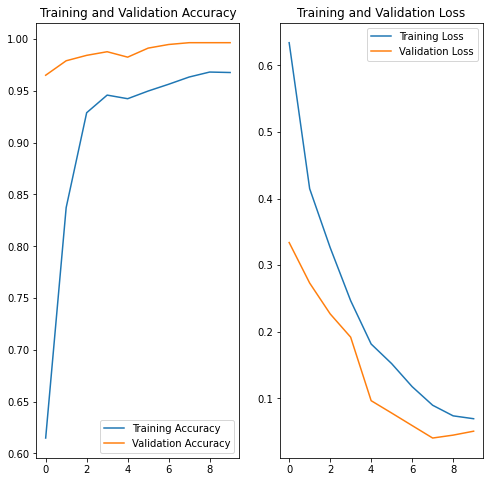

model no. 1


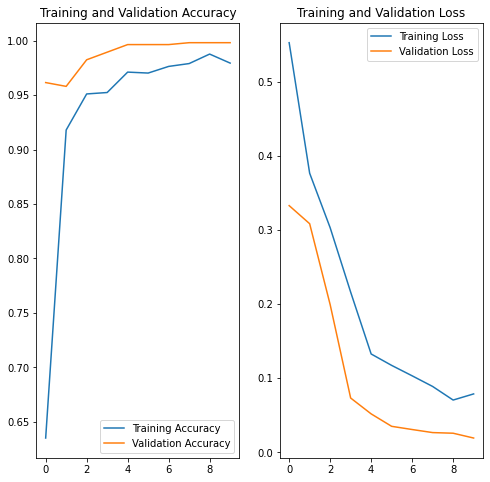

model no. 2


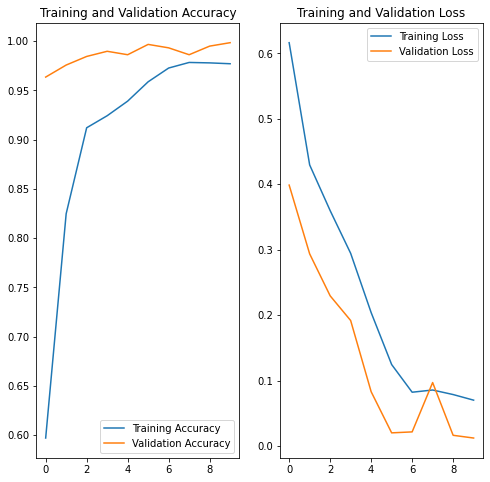

model no. 3


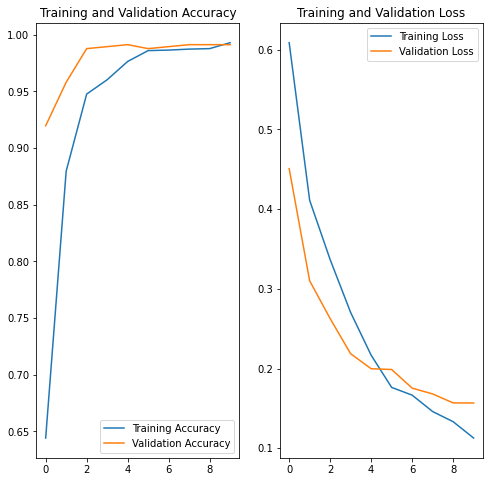

model no. 4


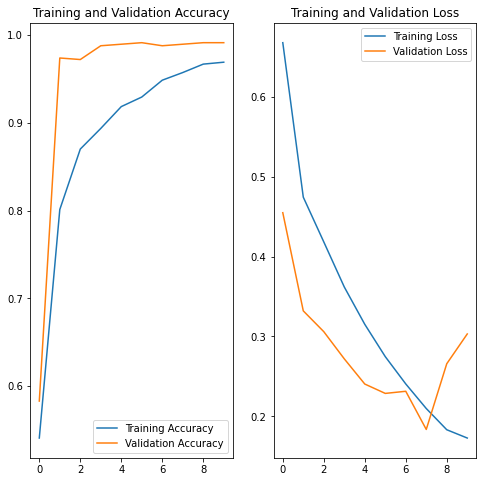

model no. 5


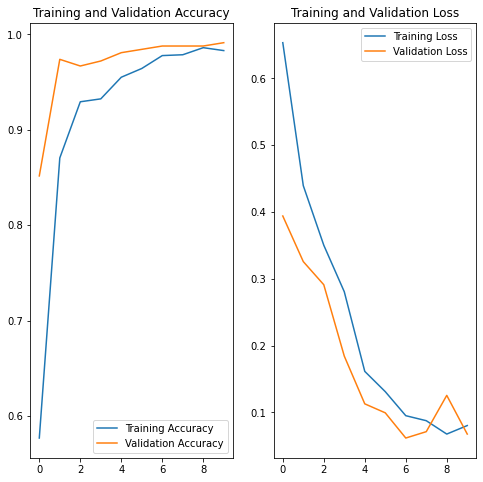

model no. 6


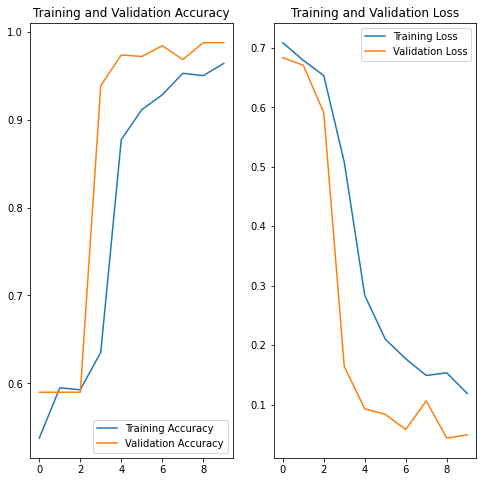

model no. 7


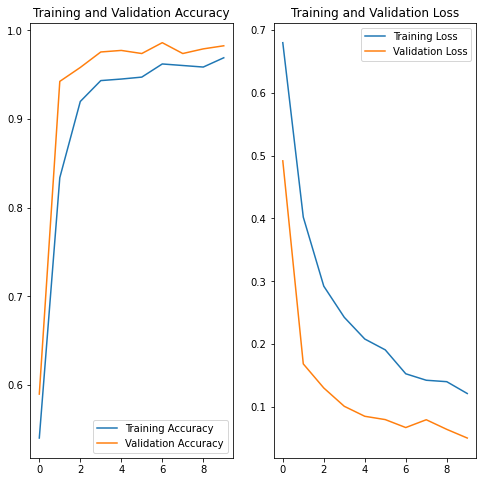

model no. 8


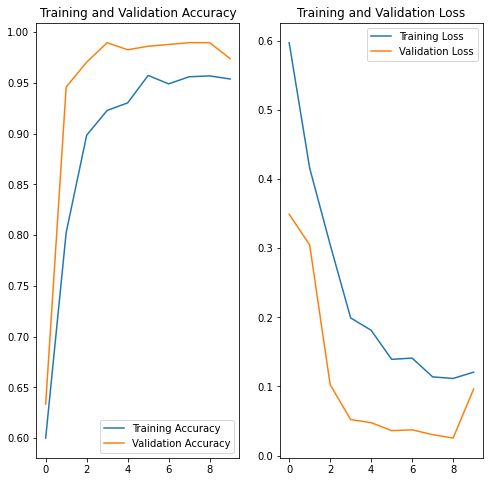

model no. 9


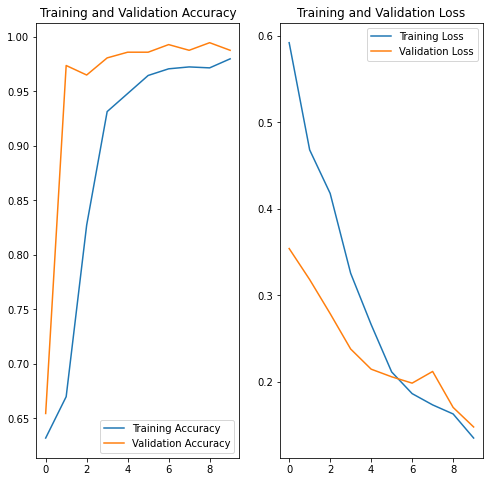

model no. 10


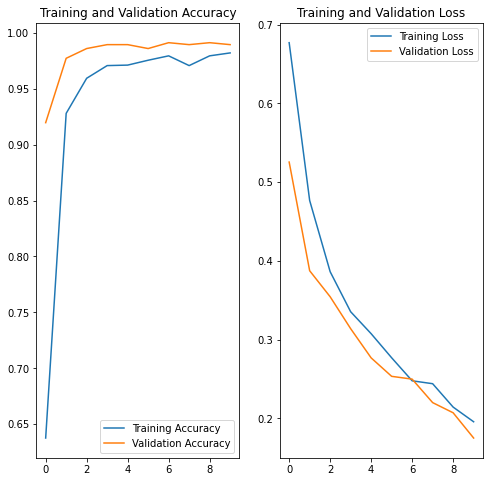

model no. 11


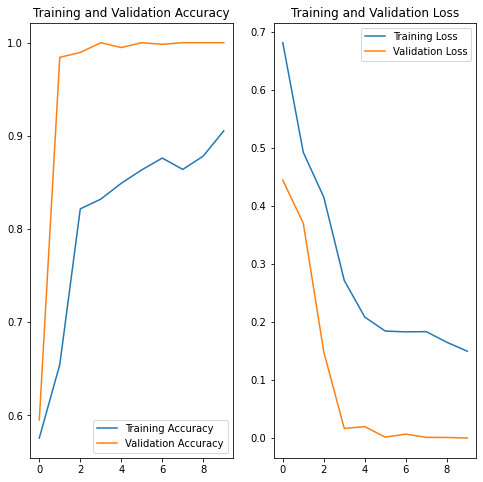

model no. 12


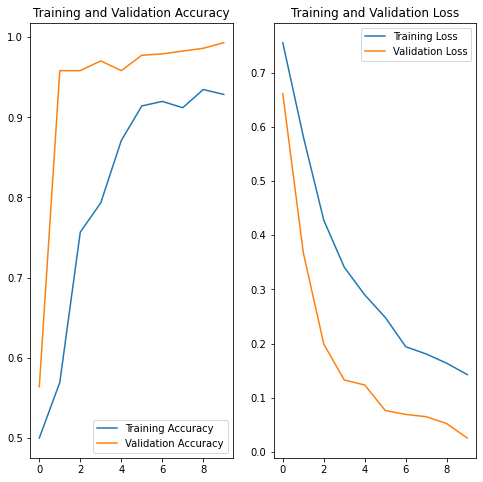

model no. 13


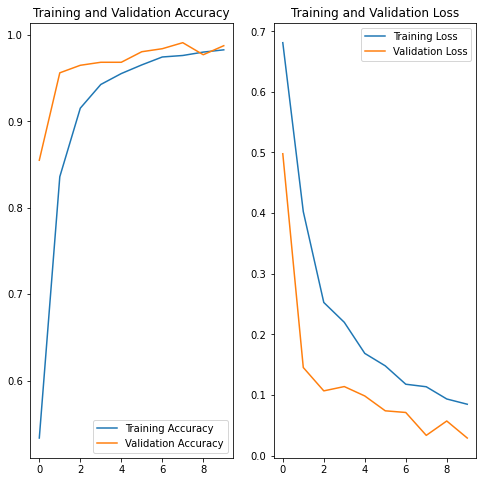

In [22]:
for i, _ in enumerate(list_history):
  print(f'model no. {i}')
  Plot(list_history[i].history['accuracy'], list_history[i].history['val_accuracy'],
       list_history[i].history['loss'], list_history[i].history['val_loss'], epochs)

**6. Model Testing and Predictions**

In [23]:
# get default ratio of keypoints
get_ann = pd.read_csv('train/_annotations.csv')
annotations = Annotations(get_ann, source_images)
list_ann = []
for i, annotation in enumerate(annotations[:40]):
  list_ann.append(annotation)

ann = Keyplot(list_ann)
xBox = ann[0]
yBox = ann[1]

In [44]:
# img_test_path = '/content/test/2013-03-22_07_50_02_jpg.rf.543aaee387b66a9d4c8c1d143251753c.jpg' # example
img_test_path = '/content/test/' + random.choice(os.listdir("/content/test"))

img = tf.keras.utils.load_img(
    img_test_path, target_size=(templatemodel.img_height, templatemodel.img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

list_prediction = []
for i, model in enumerate(list_history):
  predictions = list_model[i].predict(img_array)
  list_prediction.append(predictions)

list_score = []
for i, prediction in enumerate(list_prediction):
  score = tf.nn.softmax(prediction[0])
  list_score.append(score)

class_score = []
for i, score in enumerate(list_score):
  print(
    "Space {} was {} with a {:.2f} percent confidence."
    .format(i, class_names[np.argmax(score)], 100 * np.max(score))
    )
  class_score.append(class_names[np.argmax(score)])

Space 0 was occupied with a 100.00 percent confidence.
Space 1 was occupied with a 96.24 percent confidence.
Space 2 was occupied with a 100.00 percent confidence.
Space 3 was occupied with a 99.94 percent confidence.
Space 4 was empty with a 75.99 percent confidence.
Space 5 was empty with a 99.88 percent confidence.
Space 6 was empty with a 100.00 percent confidence.
Space 7 was occupied with a 92.84 percent confidence.
Space 8 was occupied with a 56.96 percent confidence.
Space 9 was occupied with a 99.99 percent confidence.
Space 10 was occupied with a 78.05 percent confidence.
Space 11 was occupied with a 99.82 percent confidence.
Space 12 was occupied with a 100.00 percent confidence.
Space 13 was empty with a 100.00 percent confidence.


Text(0.5, 1.0, '10 occupied and 4 empty')

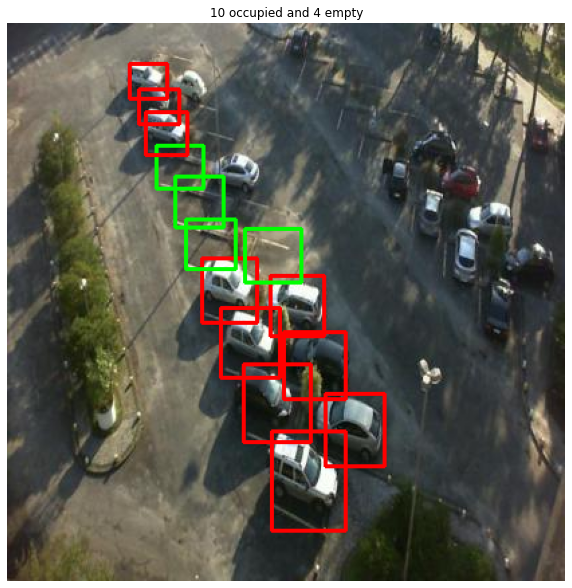

In [45]:
# plot the test
fig = plt.figure(figsize=(10, 20))

result_image = cv2.imread(img_test_path)
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

spaces_d = {'occupied': 0, 'empty': 0}
for axis, boxes in enumerate(list_ann[:14]):
  if class_score[axis] == 'occupied':
    out = cv2.rectangle(result_image, xBox[axis], yBox[axis], (255,0,0), 2)
    spaces_d['occupied'] += 1
  else:
    out = cv2.rectangle(result_image, xBox[axis], yBox[axis], (0,255,0), 2)
    spaces_d['empty'] += 1

plt.imshow(out)
plt.axis('off')
plt.title("{} occupied and {} empty".format(spaces_d['occupied'], spaces_d['empty']))

**7. Save Model**

In [49]:
# save model to h5 extension
os.mkdir('saved_model')
for index, model in enumerate(list_model[:14]):
  saved_model_path = f"/content/saved_model/{index}_space_detect.h5"
  model.save(saved_model_path)

In [50]:
from distutils.dir_util import copy_tree

In [ ]:
# copy model to drive
from_dir = '/content/saved_model'
to_dir = '/content/drive/MyDrive/saved_model'
copy_tree(from_dir, to_dir)

# OPTIONAL TESTING

**Load Saved Keras Model and Test it**

In [52]:
get_model = []
for i in range(14):
  model = tf.keras.models.load_model(f'{to_dir}/{i}_space_detect.h5')
  get_model.append(model)

In [53]:
# img_test_path = '/content/test/2013-03-22_07_50_02_jpg.rf.543aaee387b66a9d4c8c1d143251753c.jpg' # example
img_test_path = '/content/test/' + random.choice(os.listdir("/content/test"))

img = tf.keras.utils.load_img(
    img_test_path, target_size=(templatemodel.img_height, templatemodel.img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

list_prediction = []
for i, model in enumerate(list_history):
  predictions = get_model[i].predict(img_array)
  list_prediction.append(predictions)

list_score = []
for i, prediction in enumerate(list_prediction):
  score = tf.nn.softmax(prediction[0])
  list_score.append(score)

class_score = []
for i, score in enumerate(list_score):
  print(
    "Space {} was {} with a {:.2f} percent confidence."
    .format(i, class_names[np.argmax(score)], 100 * np.max(score))
    )
  class_score.append(class_names[np.argmax(score)])

Space 0 was occupied with a 100.00 percent confidence.
Space 1 was occupied with a 100.00 percent confidence.
Space 2 was occupied with a 100.00 percent confidence.
Space 3 was occupied with a 100.00 percent confidence.
Space 4 was occupied with a 100.00 percent confidence.
Space 5 was empty with a 56.38 percent confidence.
Space 6 was occupied with a 86.18 percent confidence.
Space 7 was occupied with a 98.11 percent confidence.
Space 8 was occupied with a 99.99 percent confidence.
Space 9 was occupied with a 100.00 percent confidence.
Space 10 was occupied with a 78.05 percent confidence.
Space 11 was occupied with a 100.00 percent confidence.
Space 12 was occupied with a 100.00 percent confidence.
Space 13 was occupied with a 96.37 percent confidence.


Text(0.5, 1.0, '13 occupied and 1 empty')

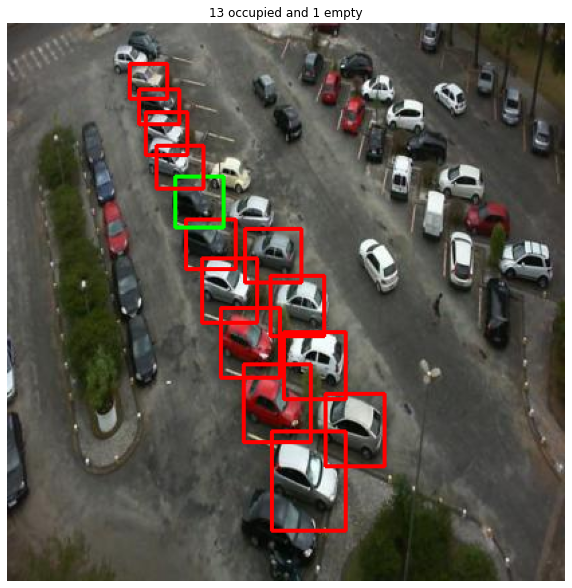

In [54]:
# plot the test
fig = plt.figure(figsize=(10, 20))

result_image = cv2.imread(img_test_path)
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

spaces_d = {'occupied': 0, 'empty': 0}
for axis, boxes in enumerate(list_ann[:14]):
  if class_score[axis] == 'occupied':
    out = cv2.rectangle(result_image, xBox[axis], yBox[axis], (255,0,0), 2)
    spaces_d['occupied'] += 1
  else:
    out = cv2.rectangle(result_image, xBox[axis], yBox[axis], (0,255,0), 2)
    spaces_d['empty'] += 1

plt.imshow(out)
plt.axis('off')
plt.title("{} occupied and {} empty".format(spaces_d['occupied'], spaces_d['empty']))